# Load Library

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, transforms
import torch
from torch.utils.data import random_split, DataLoader
import time


# Trainset과 Testset 생성.

1. cifar10 의 10가지 종류

In [15]:
class_names = ['airplane', 'car',
               'bird', 'cat',
               'deer', 'dog',
               'frog', 'horse',
               'ship', 'truck']

2. cifar10을 다운로드
3. train과 test를 위한 Dataset 생성.
  * `torch.tensor`로 변환.
  * `standaradization`을 수행.

In [16]:
data_path = os.path.join('dataset')

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ]
)

cifar10_train = datasets.CIFAR10(
    data_path,
    train = True,
    download = True,
    transform = transform,
)

cifar10_test = datasets.CIFAR10(
    data_path,
    train = False,
    download = True,
    transform = transform,
)

In [17]:
print(f'{type(transform)     = }')
print(f'{type(cifar10_train) = }')
print(f'{type(cifar10_test)  = }')

type(transform)     = <class 'torchvision.transforms.transforms.Compose'>
type(cifar10_train) = <class 'torchvision.datasets.cifar.CIFAR10'>
type(cifar10_test)  = <class 'torchvision.datasets.cifar.CIFAR10'>


In [18]:
train_size = int(0.8 * len(cifar10_train))
validation_size = len(cifar10_train) - train_size
train_set, validation_set = random_split(
    cifar10_train, [train_size, validation_size]
)


In [19]:
batch_size = 32
n_worker = 0
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = n_worker,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size = batch_size,
    shuffle = False,
    num_workers = n_worker,
)

test_loader = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size = batch_size,
    shuffle = False,
    num_workers = n_worker,
)

type(grid_img)=<class 'torch.Tensor'>
max_val.item()=2.126077890396118
min_val.item()=-1.989878535270691


(np.float64(-0.5), np.float64(273.5), np.float64(137.5), np.float64(-0.5))

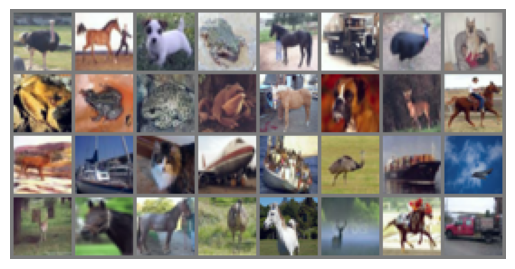

In [20]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

grid_img = torchvision.utils.make_grid(images)
max_val = torch.max(grid_img)
min_val = torch.min(grid_img)
print(f'{type(grid_img)=}\n{max_val.item()=}\n{min_val.item()=}')

normalized_grid_img = (grid_img - min_val) / (max_val - min_val)
plt.imshow(np.transpose(normalized_grid_img, (1,2,0)))
plt.axis('off')

In [21]:
cifar10_train = datasets.CIFAR10(
    data_path,
    train = True,
    download = True,
    # transform = transform,
)

In [22]:
img, label = next(iter(cifar10_train))

print(f'{type(img) = }')

type(img) = <class 'PIL.Image.Image'>


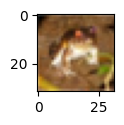

In [23]:
plt.figure(figsize=(1,1))
plt.imshow(np.array(img))

In [24]:
np.max(img)

np.uint8(255)

# Train Loop

In [25]:
def train_loop (
    n_epoch,
    train_loader, val_loader,
    model, optimizer, loss_fnc,
    device = 'cpu',):

  log_hist = torch.zeros([0,3]).to(device) # 로그 남기기위해
  tmp = torch.empty((1, 3), device=log_hist.device)

  model = model.to(device)
  start_time = time.time()  # iteration 시작 시간 기록
  for epoch in range(n_epoch):
    # print(f'\r{epoch:6>}', end='')

    model.train()
    for x_tensor, y_tensor in train_loader:

      x_tensor = x_tensor.to(device)
      y_tensor = y_tensor.to(device)
    #   x_tensor.to(device)
    #   y_tensor.to(device)

      y_pred = model(x_tensor)
      # print(y_tensor.shape)
      loss_train = loss_fnc(y_pred,y_tensor)

      if torch.isinf(loss_train):
        print(f'Error: loss is infinity!')
        break

      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()

    with torch.no_grad():
      model.eval()
      for x_tensor, y_tensor in val_loader:
        x_tensor = x_tensor.to(device)
        y_tensor = y_tensor.to(device)
        pred = model(x_tensor)
        loss_val = loss_fnc(pred, y_tensor)

    if epoch % 5 == 0:

      # tmp = torch.tensor([epoch, loss_train.item(), loss_val.item()]).to(log_hist.device)
      tmp[0, 0] = epoch
      tmp[0, 1] = loss_train.item()
      tmp[0, 2] = loss_val.item()

      # print(tmp)
      log_hist = torch.concat( (log_hist, tmp.reshape(1,-1)), dim=0 )
      end_time = time.time()  # iteration 종료 시간 기록
      iteration_time = (end_time - start_time)  # 소요 시간을 초 단위로 계산
      print(f'{epoch} Epoch [{iteration_time:.2f}s]/ loss {loss_train.item():.4f} / val_loss {loss_val.item():.4f}')

      start_time = time.time()  # iteration 시작 시간 기록

    if epoch == n_epoch-1:
      tmp[0, 0] = epoch
      tmp[0, 1] = loss_train.item()
      tmp[0, 2] = loss_val.item()
      end_time = time.time()  # iteration 종료 시간 기록
      iteration_time = (end_time - start_time)  # 소요 시간을 초 단위로 계산
      print(f'{epoch} Epoch [{iteration_time:.2f}s] / loss {loss_train.item():.4f} / val_loss {loss_val.item():.4f}')

  return model,log_hist

# Model

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # Input Channel 3, Output Channel 6, 5by5 kernel
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.pool2 = nn.MaxPool2d(2, 2)


    # Input Channel 6, Output Channel 16, 5by5 kernel
    self.conv2 = nn.Conv2d(6, 16, 5)

    # 5 by 5 Input image, 16channels = 16*5*5
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):

    # conv+relu+maxpool2d (2layers)
    x = self.pool1(F.relu(self.conv1(x)))
    # conv+relu+maxpool2d (2layers)
    x = self.pool2(F.relu(self.conv2(x)))
    # 배치를 제외한 모든 차원을 평탄화(flatten)
    x = torch.flatten(x, 1)

    # 2layers
    x = F.relu(self.fc1(x))
    # 2layers
    x = F.relu(self.fc2(x))
    # 1 layers
    x = self.fc3(x)
    return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [35]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

net = Net()
print(net)

Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, o

In [36]:
params = list(net.parameters())
for idx, param in enumerate(params):
  print(f'{idx} : {param.size()}')

# print(f'{len(params) = }')
# print(params[0].size())

0 : torch.Size([32, 3, 3, 3])
1 : torch.Size([32])
2 : torch.Size([64, 32, 3, 3])
3 : torch.Size([64])
4 : torch.Size([128, 64, 3, 3])
5 : torch.Size([128])
6 : torch.Size([128, 128, 3, 3])
7 : torch.Size([128])
8 : torch.Size([256, 128, 3, 3])
9 : torch.Size([256])
10 : torch.Size([256, 256, 3, 3])
11 : torch.Size([256])
12 : torch.Size([1024, 4096])
13 : torch.Size([1024])
14 : torch.Size([512, 1024])
15 : torch.Size([512])
16 : torch.Size([10, 512])
17 : torch.Size([10])


In [37]:
# rand input img for test
tmp = torch.randn(1, 3, 32, 32)
out = net(tmp)
print(out)

tensor([[ 0.0305, -0.0455, -0.0077, -0.0056,  0.0293, -0.0156, -0.0047,  0.0516,
          0.0016,  0.0019]], grad_fn=<AddmmBackward0>)


In [38]:
# gradient 를 0으로 초기화
net.zero_grad()
# 무작위 값으로 back propagation for test
out.backward(torch.randn(1,10))

# Training

In [39]:
# device 설정.
device = (
      "cuda" if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu"
  )
print(f"{device=}")

device='cuda'


In [40]:
# number of epochs
n_epoch = 11
# learning ratio
lr = 2e-4

# loss function 설정
loss_fnc  = nn.CrossEntropyLoss()

# 모델 생성 및 초기화
model = Net()


# optimizer 생성 및 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # recommanded

# 경사하강법(SGD) 옵티마이저로, 모델 파라미터의 업데이트를 수행한다.
# net.parameters() : 모델의 학습 가능한 파라미터들을 반환.
# lr : learning rate(학습률)을 나타낸다.
# momentum : 관성을 나타내며, 학습의 안정성과 수렴 속도를 높이는데 도움을 준다.
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

m, h = train_loop (
    n_epoch,
    train_loader, valid_loader,
    model, optimizer, loss_fnc,
    device = device)


0 Epoch [18.77s]/ loss 1.0670 / val_loss 1.3294
5 Epoch [90.77s]/ loss 0.5572 / val_loss 1.0119
10 Epoch [89.81s]/ loss 0.0694 / val_loss 1.1335
10 Epoch [0.00s] / loss 0.0694 / val_loss 1.1335


# Laerning Curve

(3, 3)


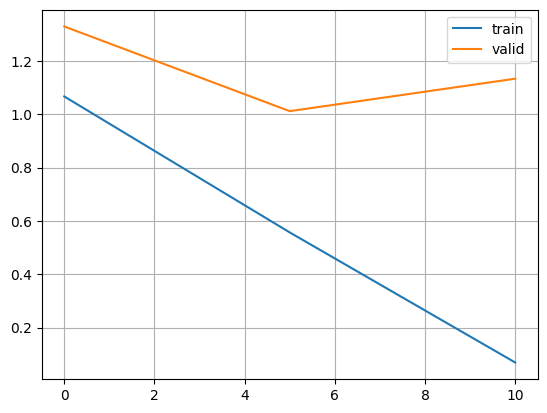

In [41]:
import matplotlib.pyplot as plt

h = h.cpu()
h0 = h.detach().numpy()
print(h0.shape)
plt.plot(h0[:,0], h0[:,1], label='train')
plt.plot(h0[:,0], h0[:,2], label='valid')
plt.legend()
plt.grid()
plt.show()

In [42]:
f_m = model.cpu()
f_m.eval()
with torch.no_grad():
  is_first = True
  for x_tensor, y_tensor in test_loader:
    x_tensor = x_tensor.cpu()
    y_tensor = y_tensor.cpu()
    pred_prob = f_m(x_tensor)
    pred = torch.argmax(pred_prob, dim=-1) # class 수 만큼 나오므로 가장 큰 확률의 index를 얻어야함.

    # print(y_tensor.numpy().shape)
    if is_first:
      test_pred = pred.numpy().copy()
      test_label = y_tensor.numpy().copy()
      is_first = False
    else:
      test_label = np.concatenate((test_label, y_tensor.numpy()), axis=0)
      test_pred = np.concatenate((test_pred, pred.numpy()), axis=0)

print(test_label.shape, test_label.dtype)
print(test_pred.shape, test_pred.dtype)

(10000,) int64
(10000,) int64


In [43]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
)
pred = test_pred
label = test_label

print('Confusion Matrix\n',
      str(confusion_matrix(label,pred))
      )
print("-"*10)
print(f'Precision           :{np.round(precision_score(label,pred,average=None),2)}')
print(f'Precision (macro)   :{np.round(precision_score(label,pred,average="macro"),2)}')
print(f'Precision (micro)   :{np.round(precision_score(label,pred,average="micro"),2)}')
print(f'Precision (weighted):{np.round(precision_score(label,pred,average="weighted"),2)}')
print("-"*10)
print(f'Recall              :{np.round(recall_score(label,pred,average=None),2)}')
print(f'Recall    (macro)   :{np.round(recall_score(label,pred,average="macro"),2)}')
print(f'Recall    (micro)   :{np.round(recall_score(label,pred,average="micro"),2)}')
print(f'Recall    (weighted):{np.round(recall_score(label,pred,average="weighted"),2)}')
print("-"*10)
print(f'F1-score            :{np.round(f1_score(label,pred,average=None),2)}')
print(f'F1-score  (macro)   :{np.round(f1_score(label,pred,average="macro"),2)}')
print(f'F1-score  (micro)   :{np.round(f1_score(label,pred,average="micro"),2)}')
print(f'F1-score  (weighted):{np.round(f1_score(label,pred,average="weighted"),2)}')
print("-"*10)
# 의료에선 F2-score 많이 씀
print(f'F2-score            :{np.round(fbeta_score(label,pred,beta=2,average=None),2)}')
print(f'F2-score  (macro)   :{np.round(fbeta_score(label,pred,beta=2,average="macro"),2)}')
print(f'F2-score  (micro)   :{np.round(fbeta_score(label,pred,beta=2,average="micro"),2)}')
print(f'F2-score  (weighted):{np.round(fbeta_score(label,pred,beta=2,average="weighted"),2)}')



Confusion Matrix
 [[855  15  57   2   5   3   9   8  28  18]
 [ 18 913   5   1   2   1   8   3  15  34]
 [ 50   2 757  23  42  30  65  20   6   5]
 [ 34   2  88 535  32 148 104  42   9   6]
 [ 17   3 104  32 688  29  49  70   5   3]
 [ 16   3  65 115  29 687  38  45   1   1]
 [  5   0  53  23  16   9 883   7   3   1]
 [  9   0  36  27  34  36   7 845   2   4]
 [ 70  22  15  12   5   2  13   5 846  10]
 [ 37  60   4   5   7   3  12  13  19 840]]
----------
Precision           :[0.77 0.9  0.64 0.69 0.8  0.72 0.74 0.8  0.91 0.91]
Precision (macro)   :0.79
Precision (micro)   :0.78
Precision (weighted):0.79
----------
Recall              :[0.86 0.91 0.76 0.54 0.69 0.69 0.88 0.84 0.85 0.84]
Recall    (macro)   :0.78
Recall    (micro)   :0.78
Recall    (weighted):0.78
----------
F1-score            :[0.81 0.9  0.69 0.6  0.74 0.71 0.81 0.82 0.87 0.87]
F1-score  (macro)   :0.78
F1-score  (micro)   :0.78
F1-score  (weighted):0.78
----------
F2-score            :[0.84 0.91 0.73 0.56 0.71 0.69 0.